数据集下载，或直接运行单元格2可以直接读取下载好的数据，防止网络问题下载失败或下载时间过长

In [31]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
  
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
# metadata 
print(individual_household_electric_power_consumption.metadata) 
  
# variable information 
print(individual_household_electric_power_consumption.variables) 

print(X.head())

# 合并日期和时间列
X['Datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'])
# 设置索引
X.set_index('Datetime', inplace=True)

# 保存数据，保留索引
X.to_csv('individual_household_electric_power_consumption_features.csv', index=True)

{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

直接读取已经下载好转换为csv的数据，减少下载时间
对数据进行预处理，提取时间特征，填充缺失值等

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取数据，保留时间索引
X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)

# 选取global_active_power作为预测目标
X = X['Global_active_power'].replace('?', np.nan).astype(float) # 替换缺失值并转换为float类型
X = X.resample('H').mean()  # 按小时重采样并计算均值

# Handle missing values
X.fillna(method='ffill', inplace=True)      #向前填充
X.fillna(method='bfill', inplace=True)      #向后填充

scaler = MinMaxScaler()  # 创建归一化器
X = scaler.fit_transform(X.values.reshape(-1, 1)).flatten()  # 训练集归一化



/tmp/ipykernel_90095/735023100.py:6: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_90095/735023100.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_90095/735023100.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X = X.resample('H').mean()  # 按小时重采样并计算均值
/tmp/ipykernel_90095/735023100.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)      #向前填充
/tmp/ipykernel_90095/73502

滑动窗口法构建时间序列数据集

将时间序列数据划分为输入序列和目标值，形成监督学习的数据

In [3]:
from torch.utils.data import Dataset
import torch

# 构建时序数据集，输入为前seq_len，输出为第seq_len+1
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len=24):
        self.data = data  # 归一化后的一维数组
        self.seq_len = seq_len  # 序列长度（如24小时）

    def __len__(self):
        return len(self.data) - self.seq_len  # 可用样本数

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]  # 输入序列
        y = self.data[idx+self.seq_len]      # 目标值
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
# 将归一化后的数据分割为训练集和验证集
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_val = X[train_size:]
print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")

batch_size = 1024
# 创建训练和验证数据集
train_dataset = SequenceDataset(X_train, seq_len=24)        #前24小时预测第25小时
val_dataset = SequenceDataset(X_val, seq_len=24)        #前24小时预测第25小时

NameError: name 'X' is not defined

lstm模型定义与预测

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
# 设置中文字体，用于图表显示
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示负号
plt.rcParams['axes.unicode_minus'] = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)     
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# 优化的LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM层，添加dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # 多层全连接网络
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()       # 激活函数层，增加网络的非线性表达能力，使模型能够拟合更复杂的数据关系。

    def forward(self, x):
        x = x.unsqueeze(-1)    # (batch, seq_len, 1)
        # LSTM前向传播
        out, _ = self.lstm(x)
        out = out[:, -1, :]    # 取最后一个时间步
        # 多层全连接 + dropout
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
# 创建模型
model = LSTMModel(input_size=1, hidden_size=128, num_layers=3, dropout=0.2).to(device)
# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型参数量: {total_params:,}")
# 优化器添加权重衰减
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 训练循环
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 5
for epoch in range(num_epochs):
    # ============ 训练阶段 ============
    model.train()
    train_loss = 0
    train_batches = 0
    
    # 训练进度条
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', 
                      ncols=100, leave=False)
    for x, y in train_pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        y_pred = model(x).squeeze()
        loss = loss_fn(y_pred, y)
        loss.backward()
        # 梯度裁剪防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_batches += 1
        
        # 更新进度条显示当前loss
        train_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_train_loss = train_loss / train_batches
    
    # ============ 验证阶段 ============
    model.eval()
    val_loss = 0
    val_batches = 0
    
    # 验证进度条
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', 
                    ncols=100, leave=False)
    with torch.no_grad():
        for x, y in val_pbar:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(x).squeeze()
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_batches += 1
            
            # 更新验证进度条
            val_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_val_loss = val_loss / val_batches
    # 学习率调度
    scheduler.step(avg_val_loss)
    # 记录损失
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    # 显示epoch结果
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}')
    
    # 早停
    if patience_counter >= patience:
        print(f"早停于epoch {epoch+1}，最佳模型在epoch {best_epoch}")
        break

print(f"\n训练完成！")
print(f"最佳验证损失: {best_val_loss:.6f} (epoch {best_epoch})")

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 可视化训练过程
plt.figure(figsize=(15, 5))
# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', color='blue')
plt.plot(val_losses, label='验证损失', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练过程损失变化')
plt.legend()
plt.grid(True)
# 过拟合分析
plt.subplot(1, 2, 2)
overfitting_ratio = [v/t if t > 0 else 1 for t, v in zip(train_losses, val_losses)]
plt.plot(overfitting_ratio, label='验证/训练损失比', color='green')
plt.axhline(y=1.2, color='orange', linestyle='--', label='过拟合警戒线')
plt.xlabel('Epoch')
plt.ylabel('比值')
plt.title('过拟合监控')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 性能总结
print("\n=== 训练总结 ===")
print(f"最终训练损失: {train_losses[-1]:.6f}")
print(f"最终验证损失: {val_losses[-1]:.6f}")
print(f"最佳验证损失: {best_val_loss:.6f}")
print(f"过拟合程度: {val_losses[-1]/train_losses[-1]:.2f} ({'正常' if val_losses[-1]/train_losses[-1] < 1.5 else '可能过拟合'})")
print(f"模型已保存为: best_model.pth")



# 在验证集上评估
model.eval()  # 评估模式
val_preds = []
val_targets = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y_pred = model(x).squeeze().cpu().numpy()  # 预测值
        val_preds.extend(y_pred)
        val_targets.extend(y.numpy())
# 计算评估指标
val_preds = np.array(val_preds)
val_targets = np.array(val_targets)
mse = mean_squared_error(val_targets, val_preds)
mae = mean_absolute_error(val_targets, val_preds)
mape = mean_absolute_percentage_error(val_targets, val_preds) 
r2 = r2_score(val_targets, val_preds)

#反归一化
val_preds = scaler.inverse_transform(val_preds.reshape(-1, 1)).flatten()
val_targets = scaler.inverse_transform(val_targets.reshape(-1, 1)).flatten()

#画预测值与真实值对比图
plt.figure(figsize=(24, 6))
plt.plot(val_targets, label='真实值', color='blue')
plt.plot(val_preds, label='预测值', color='red', alpha=0.7)
plt.xlabel('时间步')
plt.ylabel('Global Active Power')
plt.title('LSTM模型预测结果对比')
plt.legend()
plt.show()
print(f'验证集 MSE: {mse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}, R2: {r2:.6f}')

NameError: name 'train_dataset' is not defined

# 多家庭lstm


数据提取

In [1]:
import numpy as np
import pandas as pd
import glob
import os

# 查找所有CSV文件
csv_files = glob.glob('./Data-PecanStreet/*.csv')

# 读取并合并所有CSV文件
data_list = []
for file in csv_files:
    df = pd.read_csv(file)
    print(f"成功读取 {file}: {df.shape}")
    df['local_15min'] = pd.to_datetime(df['local_15min'], utc=True)
    df = df.resample('h', on='local_15min').mean().reset_index()  # 按小时重采样并计算均值
    data_list.append(df)

# 合并所有数据
data = pd.concat(data_list, ignore_index=True)

# 数据预处理
data = data.fillna(value=0)
data = data[['dataid','local_15min','grid']].reset_index(drop=True)

print(data.head())


成功读取 ./Data-PecanStreet/661.csv: (35032, 79)
成功读取 ./Data-PecanStreet/8386.csv: (35036, 79)
成功读取 ./Data-PecanStreet/9278.csv: (35035, 79)
成功读取 ./Data-PecanStreet/7951.csv: (35036, 79)
成功读取 ./Data-PecanStreet/8565.csv: (35036, 79)
成功读取 ./Data-PecanStreet/9278.csv: (35035, 79)
成功读取 ./Data-PecanStreet/7951.csv: (35036, 79)
成功读取 ./Data-PecanStreet/8565.csv: (35036, 79)
成功读取 ./Data-PecanStreet/3538.csv: (35036, 79)
成功读取 ./Data-PecanStreet/9922.csv: (35036, 79)
成功读取 ./Data-PecanStreet/6139.csv: (35036, 79)
成功读取 ./Data-PecanStreet/3538.csv: (35036, 79)
成功读取 ./Data-PecanStreet/9922.csv: (35036, 79)
成功读取 ./Data-PecanStreet/6139.csv: (35036, 79)
成功读取 ./Data-PecanStreet/4031.csv: (35036, 79)
成功读取 ./Data-PecanStreet/3039.csv: (35036, 79)
   dataid               local_15min     grid
0   661.0 2018-01-01 06:00:00+00:00  0.00000
1   661.0 2018-01-01 07:00:00+00:00  1.54650
2   661.0 2018-01-01 08:00:00+00:00  1.11000
3   661.0 2018-01-01 09:00:00+00:00  0.96750
4   661.0 2018-01-01 10:00:00+00:00  0.7

家庭嵌入

In [2]:
from torch.utils.data import Dataset
import torch
from sklearn.preprocessing import MinMaxScaler

# 支持多家庭的时序数据集
class MultiHouseholdSequenceDataset(Dataset):
    def __init__(self, data, household_codes, seq_len=24):
        """
        多家庭时序数据集
        data: 归一化后的用电量数据
        household_codes: 对应的家庭ID编码
        """
        self.data = data
        self.household_codes = household_codes
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        # 输入序列（前seq_len个时间步）
        x = self.data[idx:idx+self.seq_len]  
        # 目标值（第seq_len+1个时间步）
        y = self.data[idx+self.seq_len]
        # 对应的家庭ID（取目标时间步的家庭ID）
        household_id = self.household_codes[idx+self.seq_len]
        
        return (torch.tensor(x, dtype=torch.float32), 
                torch.tensor(household_id, dtype=torch.long),
                torch.tensor(y, dtype=torch.float32))

# 按家庭分别处理数据并划分训练/验证集
def prepare_multihousehold_data(data, train_ratio=0.8, seq_len=24, min_data_points=100):
    """
    按家庭分别划分训练和验证集
    """
    # 首先过滤掉异常家庭（数据点太少或异常值）
    print(f"\n=== 数据预处理和家庭过滤 ===")
    unique_households = data['dataid'].unique()
    valid_households = []
    
    for household_id in unique_households:
        household_data = data[data['dataid'] == household_id]
        data_count = len(household_data)
        
        # 过滤条件：数据点数量足够且不是异常值（如0.0）
        if data_count >= min_data_points and household_id != 0.0:
            valid_households.append(household_id)
            print(f"保留家庭 {household_id}: {data_count} 个数据点")
        else:
            print(f"过滤家庭 {household_id}: 数据点不足 ({data_count} < {min_data_points}) 或为异常值")
    
    # 只保留有效家庭的数据
    data_filtered = data[data['dataid'].isin(valid_households)].copy()
    print(f"\n过滤后保留 {len(valid_households)} 个有效家庭")
    print(f"过滤后数据总量: {len(data_filtered)} 个数据点")
    
    # 检查并处理异常值
    print(f"\n处理前 - Grid列中的NaN数量: {data_filtered['grid'].isna().sum()}")
    print(f"处理前 - Grid列中的无穷大数量: {np.isinf(data_filtered['grid']).sum()}")
    print(f"处理前 - Grid列的范围: {data_filtered['grid'].min():.6f} 到 {data_filtered['grid'].max():.6f}")
    
    # 处理NaN值
    data_filtered['grid'] = data_filtered['grid'].fillna(method='ffill')
    data_filtered['grid'] = data_filtered['grid'].fillna(method='bfill')
    
    if data_filtered['grid'].isna().any():
        mean_value = data_filtered['grid'].mean()
        data_filtered['grid'] = data_filtered['grid'].fillna(mean_value)
        print(f"用均值 {mean_value:.6f} 填充剩余的 NaN")
    
    print(f"\n处理后 - Grid列中的NaN数量: {data_filtered['grid'].isna().sum()}")
    print(f"处理后 - Grid列中的无穷大数量: {np.isinf(data_filtered['grid']).sum()}")
    print(f"处理后 - Grid列的范围: {data_filtered['grid'].min():.6f} 到 {data_filtered['grid'].max():.6f}")
    
    # 全局归一化
    scaler = MinMaxScaler()
    grid_values = data_filtered['grid'].values.reshape(-1, 1)
    data_filtered['grid'] = scaler.fit_transform(grid_values).flatten()
    
    # 重新生成家庭ID编码（确保连续编码）
    household_codes = data_filtered['dataid'].astype('category').cat.codes
    
    print(f"\n=== 多家庭数据划分 ===")
    print(f"有效家庭数: {len(valid_households)}")
    
    # 分别为每个家庭划分训练/验证集
    train_data_list = []
    train_household_list = []
    val_data_list = []
    val_household_list = []
    
    for household_id in valid_households:
        # 获取该家庭的数据
        household_mask = data_filtered['dataid'] == household_id
        household_data = data_filtered[household_mask]
        household_grid = household_data['grid'].values
        household_codes_subset = household_codes[household_mask].values
        
        # 计算该家庭的训练集大小
        household_size = len(household_data)
        household_train_size = int(household_size * train_ratio)
        
        # 确保有足够的数据进行时序建模
        if household_train_size < seq_len + 1:
            print(f"警告: 家庭 {household_id} 训练数据不足 (只有 {household_train_size} 个点)")
            continue
            
        if household_size - household_train_size < seq_len + 1:
            print(f"调整: 家庭 {household_id} 验证数据不足，调整划分比例")
            # 调整划分比例
            household_train_size = household_size - seq_len - 1
            
        # 划分该家庭的训练/验证数据
        train_grid = household_grid[:household_train_size]
        train_codes = household_codes_subset[:household_train_size]
        val_grid = household_grid[household_train_size:]
        val_codes = household_codes_subset[household_train_size:]
        
        train_data_list.append(train_grid)
        train_household_list.append(train_codes)
        val_data_list.append(val_grid)
        val_household_list.append(val_codes)
        
        print(f"家庭 {household_id}: 训练数据 {len(train_grid)} 点, 验证数据 {len(val_grid)} 点")
    
    # 合并所有家庭的训练/验证数据
    train_data = np.concatenate(train_data_list)
    train_household_codes = np.concatenate(train_household_list)
    val_data = np.concatenate(val_data_list)
    val_household_codes = np.concatenate(val_household_list)
    
    print(f"\n=== 最终数据统计 ===")
    print(f"训练集大小: {len(train_data)} 个数据点")
    print(f"验证集大小: {len(val_data)} 个数据点")
    
    # 最终检查
    print(f"\n最终数据检查:")
    print(f"训练数据中的NaN: {np.isnan(train_data).sum()}")
    print(f"验证数据中的NaN: {np.isnan(val_data).sum()}")
    print(f"训练数据中的无穷大: {np.isinf(train_data).sum()}")
    print(f"验证数据中的无穷大: {np.isinf(val_data).sum()}")
    
    return train_data, train_household_codes, val_data, val_household_codes, scaler, valid_households

# 执行数据准备
train_data, train_household_codes, val_data, val_household_codes, scaler, valid_households = prepare_multihousehold_data(data)

# 获取有效家庭数量（用于模型定义）
num_unique_households = len(valid_households)
print(f"有效家庭数量: {num_unique_households}")
print(f"有效家庭列表: {valid_households}")

# 创建多家庭数据集
train_dataset = MultiHouseholdSequenceDataset(train_data, train_household_codes, seq_len=24)
val_dataset = MultiHouseholdSequenceDataset(val_data, val_household_codes, seq_len=24)

print(f"\n数据集大小:")
print(f"训练数据集: {len(train_dataset)} 个样本")
print(f"验证数据集: {len(val_dataset)} 个样本")


=== 数据预处理和家庭过滤 ===
保留家庭 661.0: 8758 个数据点
过滤家庭 0.0: 数据点不足 (11 < 100) 或为异常值
保留家庭 8386.0: 8759 个数据点
保留家庭 9278.0: 8759 个数据点
保留家庭 7951.0: 8759 个数据点
保留家庭 8565.0: 8759 个数据点
保留家庭 3538.0: 8759 个数据点
保留家庭 9922.0: 8759 个数据点
保留家庭 6139.0: 8759 个数据点
保留家庭 4031.0: 8759 个数据点
保留家庭 3039.0: 8759 个数据点

过滤后保留 10 个有效家庭
过滤后数据总量: 87589 个数据点

处理前 - Grid列中的NaN数量: 0
处理前 - Grid列中的无穷大数量: 0
处理前 - Grid列的范围: -4.698500 到 14.088250

处理后 - Grid列中的NaN数量: 0
处理后 - Grid列中的无穷大数量: 0
处理后 - Grid列的范围: -4.698500 到 14.088250

=== 多家庭数据划分 ===
有效家庭数: 10
家庭 661.0: 训练数据 7006 点, 验证数据 1752 点
家庭 8386.0: 训练数据 7007 点, 验证数据 1752 点
家庭 9278.0: 训练数据 7007 点, 验证数据 1752 点
家庭 7951.0: 训练数据 7007 点, 验证数据 1752 点
家庭 8565.0: 训练数据 7007 点, 验证数据 1752 点
家庭 3538.0: 训练数据 7007 点, 验证数据 1752 点
家庭 9922.0: 训练数据 7007 点, 验证数据 1752 点
家庭 6139.0: 训练数据 7007 点, 验证数据 1752 点
家庭 4031.0: 训练数据 7007 点, 验证数据 1752 点
家庭 3039.0: 训练数据 7007 点, 验证数据 1752 点

=== 最终数据统计 ===
训练集大小: 70069 个数据点
验证集大小: 17520 个数据点

最终数据检查:
训练数据中的NaN: 0
验证数据中的NaN: 0
训练数据中的无穷大: 0
验证数据中的无穷大: 0
有效家庭数量: 10
有效家庭列表

/tmp/ipykernel_34814/1460671129.py:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filtered['grid'] = data_filtered['grid'].fillna(method='ffill')
/tmp/ipykernel_34814/1460671129.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filtered['grid'] = data_filtered['grid'].fillna(method='bfill')


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
# 设置中文字体，用于图表显示
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示负号
plt.rcParams['axes.unicode_minus'] = True

# 支持家庭嵌入的LSTM模型
class MultiHouseholdLSTMModel(nn.Module):
    def __init__(self, num_households, input_size=1, hidden_size=128, 
                 embedding_dim=16, num_layers=3, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        # 家庭嵌入层
        self.household_embedding = nn.Embedding(num_households, embedding_dim)
        # LSTM层处理时序数据
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # 融合LSTM输出和家庭嵌入
        self.fusion_layer = nn.Linear(hidden_size + embedding_dim, hidden_size)
        # 输出层
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x, household_ids):
        # x: [batch_size, seq_len]
        # household_ids: [batch_size]
        # 处理时序数据
        x = x.unsqueeze(-1)  # [batch_size, seq_len, 1]
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 取最后一个时间步 [batch_size, hidden_size]
        
        # 获取家庭嵌入
        household_emb = self.household_embedding(household_ids)  # [batch_size, embedding_dim]
        
        # 融合LSTM输出和家庭嵌入
        combined = torch.cat([lstm_out, household_emb], dim=1)  # [batch_size, hidden_size + embedding_dim]
        fused = self.relu(self.fusion_layer(combined))  # [batch_size, hidden_size]
        
        # 最终预测
        out = self.dropout(fused)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# 创建数据加载器
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)     
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 创建多家庭LSTM模型
model = MultiHouseholdLSTMModel(
    num_households=num_unique_households,
    input_size=1, 
    hidden_size=128, 
    embedding_dim=32,
    num_layers=3, 
    dropout=0.2
).to(device)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"多家庭LSTM模型参数量: {total_params:,}")

# 优化器添加权重衰减
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

使用设备: cuda
多家庭LSTM模型参数量: 360,513



开始训练多家庭LSTM模型...
训练集样本数: 70045
验证集样本数: 17496


Epoch 1/50 | Train Loss: 0.008131 | Val Loss: 0.003667 | LR: 0.001000


Epoch 2/50 | Train Loss: 0.003948 | Val Loss: 0.001335 | LR: 0.001000


Epoch 3/50 | Train Loss: 0.002569 | Val Loss: 0.001316 | LR: 0.001000


Epoch 4/50 | Train Loss: 0.002361 | Val Loss: 0.001257 | LR: 0.001000


Epoch 5/50 | Train Loss: 0.002260 | Val Loss: 0.001232 | LR: 0.001000


Epoch 6/50 | Train Loss: 0.002189 | Val Loss: 0.001292 | LR: 0.001000


Epoch 7/50 | Train Loss: 0.002132 | Val Loss: 0.001293 | LR: 0.001000


Epoch 8/50 | Train Loss: 0.002089 | Val Loss: 0.001220 | LR: 0.001000


Epoch 9/50 | Train Loss: 0.002019 | Val Loss: 0.001191 | LR: 0.001000


Epoch 10/50 | Train Loss: 0.001857 | Val Loss: 0.001136 | LR: 0.001000


Epoch 11/50 | Train Loss: 0.001786 | Val Loss: 0.001144 | LR: 0.001000


Epoch 12/50 | Train Loss: 0.001784 | Val Loss: 0.001188 | LR: 0.001000


Epoch 13/50 | Train Loss: 0.001757 | Val Loss: 0.001129 | LR: 0.001000


Epoch 14/50 | Train Loss: 0.001757 | Val Loss: 0.001142 | LR: 0.001000


Epoch 15/50 | Train Loss: 0.001750 | Val Loss: 0.001104 | LR: 0.001000


Epoch 16/50 | Train Loss: 0.001746 | Val Loss: 0.001140 | LR: 0.001000


Epoch 17/50 | Train Loss: 0.001716 | Val Loss: 0.001109 | LR: 0.001000


Epoch 18/50 | Train Loss: 0.001734 | Val Loss: 0.001130 | LR: 0.001000


Epoch 19/50 | Train Loss: 0.001725 | Val Loss: 0.001125 | LR: 0.000500


Epoch 20/50 | Train Loss: 0.001680 | Val Loss: 0.001082 | LR: 0.000500


Epoch 21/50 | Train Loss: 0.001668 | Val Loss: 0.001091 | LR: 0.000500


Epoch 22/50 | Train Loss: 0.001680 | Val Loss: 0.001074 | LR: 0.000500


Epoch 23/50 | Train Loss: 0.001689 | Val Loss: 0.001074 | LR: 0.000500


Epoch 24/50 | Train Loss: 0.001686 | Val Loss: 0.001104 | LR: 0.000500


Epoch 25/50 | Train Loss: 0.001677 | Val Loss: 0.001117 | LR: 0.000500


Epoch 26/50 | Train Loss: 0.001675 | Val Loss: 0.001071 | LR: 0.000500


Epoch 27/50 | Train Loss: 0.001668 | Val Loss: 0.001084 | LR: 0.000500


Epoch 28/50 | Train Loss: 0.001668 | Val Loss: 0.001080 | LR: 0.000500


Epoch 29/50 | Train Loss: 0.001684 | Val Loss: 0.001196 | LR: 0.000500


Epoch 30/50 | Train Loss: 0.001676 | Val Loss: 0.001088 | LR: 0.000250


Epoch 31/50 | Train Loss: 0.001643 | Val Loss: 0.001064 | LR: 0.000250


Epoch 32/50 | Train Loss: 0.001653 | Val Loss: 0.001065 | LR: 0.000250


Epoch 33/50 | Train Loss: 0.001641 | Val Loss: 0.001071 | LR: 0.000250


Epoch 34/50 | Train Loss: 0.001637 | Val Loss: 0.001119 | LR: 0.000250


Epoch 35/50 | Train Loss: 0.001644 | Val Loss: 0.001082 | LR: 0.000125


Epoch 36/50 | Train Loss: 0.001632 | Val Loss: 0.001071 | LR: 0.000125


Epoch 37/50 | Train Loss: 0.001632 | Val Loss: 0.001067 | LR: 0.000125


Epoch 38/50 | Train Loss: 0.001632 | Val Loss: 0.001053 | LR: 0.000125


Epoch 39/50 | Train Loss: 0.001629 | Val Loss: 0.001064 | LR: 0.000125


Epoch 40/50 | Train Loss: 0.001635 | Val Loss: 0.001059 | LR: 0.000125


Epoch 41/50 | Train Loss: 0.001626 | Val Loss: 0.001055 | LR: 0.000125


Epoch 42/50 | Train Loss: 0.001628 | Val Loss: 0.001059 | LR: 0.000063


Epoch 43/50 | Train Loss: 0.001619 | Val Loss: 0.001057 | LR: 0.000063


Epoch 44/50 | Train Loss: 0.001626 | Val Loss: 0.001068 | LR: 0.000063


Epoch 45/50 | Train Loss: 0.001622 | Val Loss: 0.001063 | LR: 0.000063


Epoch 46/50 | Train Loss: 0.001626 | Val Loss: 0.001048 | LR: 0.000063


Epoch 47/50 | Train Loss: 0.001609 | Val Loss: 0.001064 | LR: 0.000063


Epoch 48/50 | Train Loss: 0.001620 | Val Loss: 0.001049 | LR: 0.000063


Epoch 49/50 | Train Loss: 0.001618 | Val Loss: 0.001053 | LR: 0.000063


Epoch 50/50 | Train Loss: 0.001616 | Val Loss: 0.001055 | LR: 0.000031

训练完成！
最佳验证损失: 0.001048 (epoch 46)


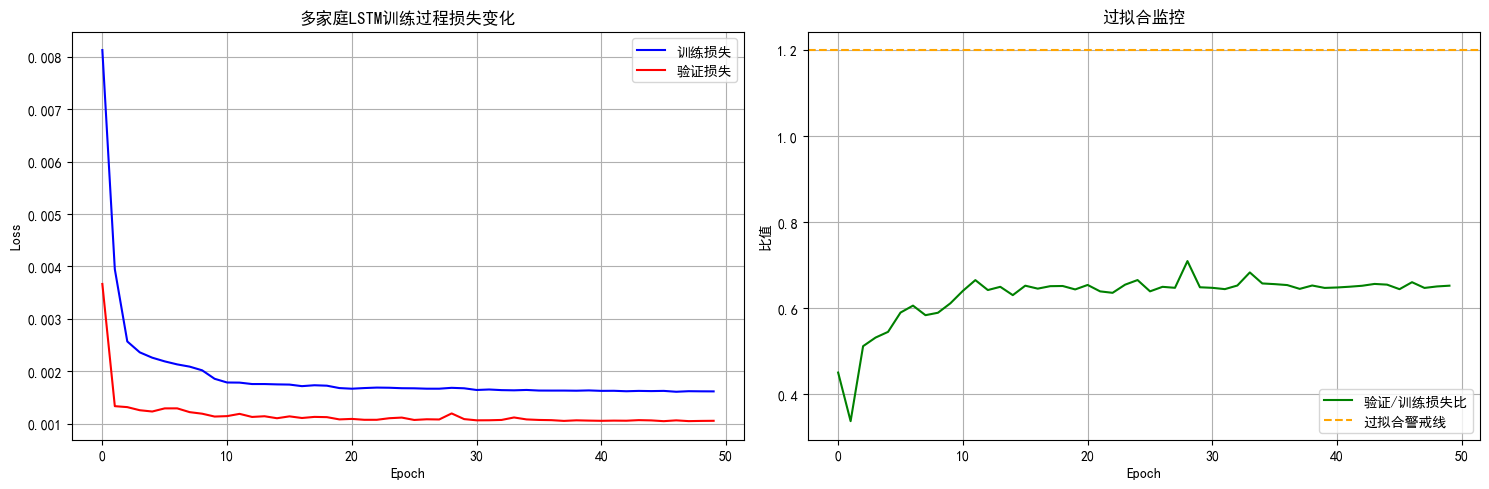


=== 多家庭LSTM训练总结 ===
最终训练损失: 0.001616
最终验证损失: 0.001055
最佳验证损失: 0.001048
过拟合程度: 0.65 (正常)
模型已保存为: best_model_multihousehold.pth


In [12]:
# 训练循环
num_epochs = 50  
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
patience = 8

print(f"\n开始训练多家庭LSTM模型...")
print(f"训练集样本数: {len(train_dataset)}")
print(f"验证集样本数: {len(val_dataset)}")

for epoch in range(num_epochs):
    # ============ 训练阶段 ============
    model.train()
    train_loss = 0
    train_batches = 0
    
    # 训练进度条
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', 
                      ncols=100, leave=False)
    for x, household_ids, y in train_pbar:
        x = x.to(device, non_blocking=True)
        household_ids = household_ids.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        y_pred = model(x, household_ids).squeeze()
        loss = loss_fn(y_pred, y)
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        # 更新进度条显示当前loss
        train_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_train_loss = train_loss / train_batches
    
    # ============ 验证阶段 ============
    model.eval()
    val_loss = 0
    val_batches = 0
    
    # 验证进度条
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', 
                    ncols=100, leave=False)
    with torch.no_grad():
        for x, household_ids, y in val_pbar:
            x = x.to(device, non_blocking=True)
            household_ids = household_ids.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            
            y_pred = model(x, household_ids).squeeze()
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_batches += 1
            
            # 更新验证进度条
            val_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_val_loss = val_loss / val_batches
    
    # 学习率调度
    scheduler.step(avg_val_loss)
    # 记录损失
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model_multihousehold.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    # 显示epoch结果
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}')
    
    # 早停
    if patience_counter >= patience:
        print(f"早停于epoch {epoch+1}，最佳模型在epoch {best_epoch}")
        break

print(f"\n训练完成！")
print(f"最佳验证损失: {best_val_loss:.6f} (epoch {best_epoch})")

# 加载最佳模型
if best_epoch > 0:
    model.load_state_dict(torch.load('best_model_multihousehold.pth'))

# 可视化训练过程
plt.figure(figsize=(15, 5))
# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', color='blue')
plt.plot(val_losses, label='验证损失', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('多家庭LSTM训练过程损失变化')
plt.legend()
plt.grid(True)
# 过拟合分析
plt.subplot(1, 2, 2)
overfitting_ratio = [v/t if t > 0 else 1 for t, v in zip(train_losses, val_losses)]
plt.plot(overfitting_ratio, label='验证/训练损失比', color='green')
plt.axhline(y=1.2, color='orange', linestyle='--', label='过拟合警戒线')
plt.xlabel('Epoch')
plt.ylabel('比值')
plt.title('过拟合监控')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 性能总结
print("\n=== 多家庭LSTM训练总结 ===")
print(f"最终训练损失: {train_losses[-1]:.6f}")
print(f"最终验证损失: {val_losses[-1]:.6f}")
print(f"最佳验证损失: {best_val_loss:.6f}")
print(f"过拟合程度: {val_losses[-1]/train_losses[-1]:.2f} ({'正常' if val_losses[-1]/train_losses[-1] < 1.5 else '可能过拟合'})")
print(f"模型已保存为: best_model_multihousehold.pth")

正在收集验证集预测结果...
共 17496 个预测样本
10 个不同家庭
共 17496 个预测样本
10 个不同家庭


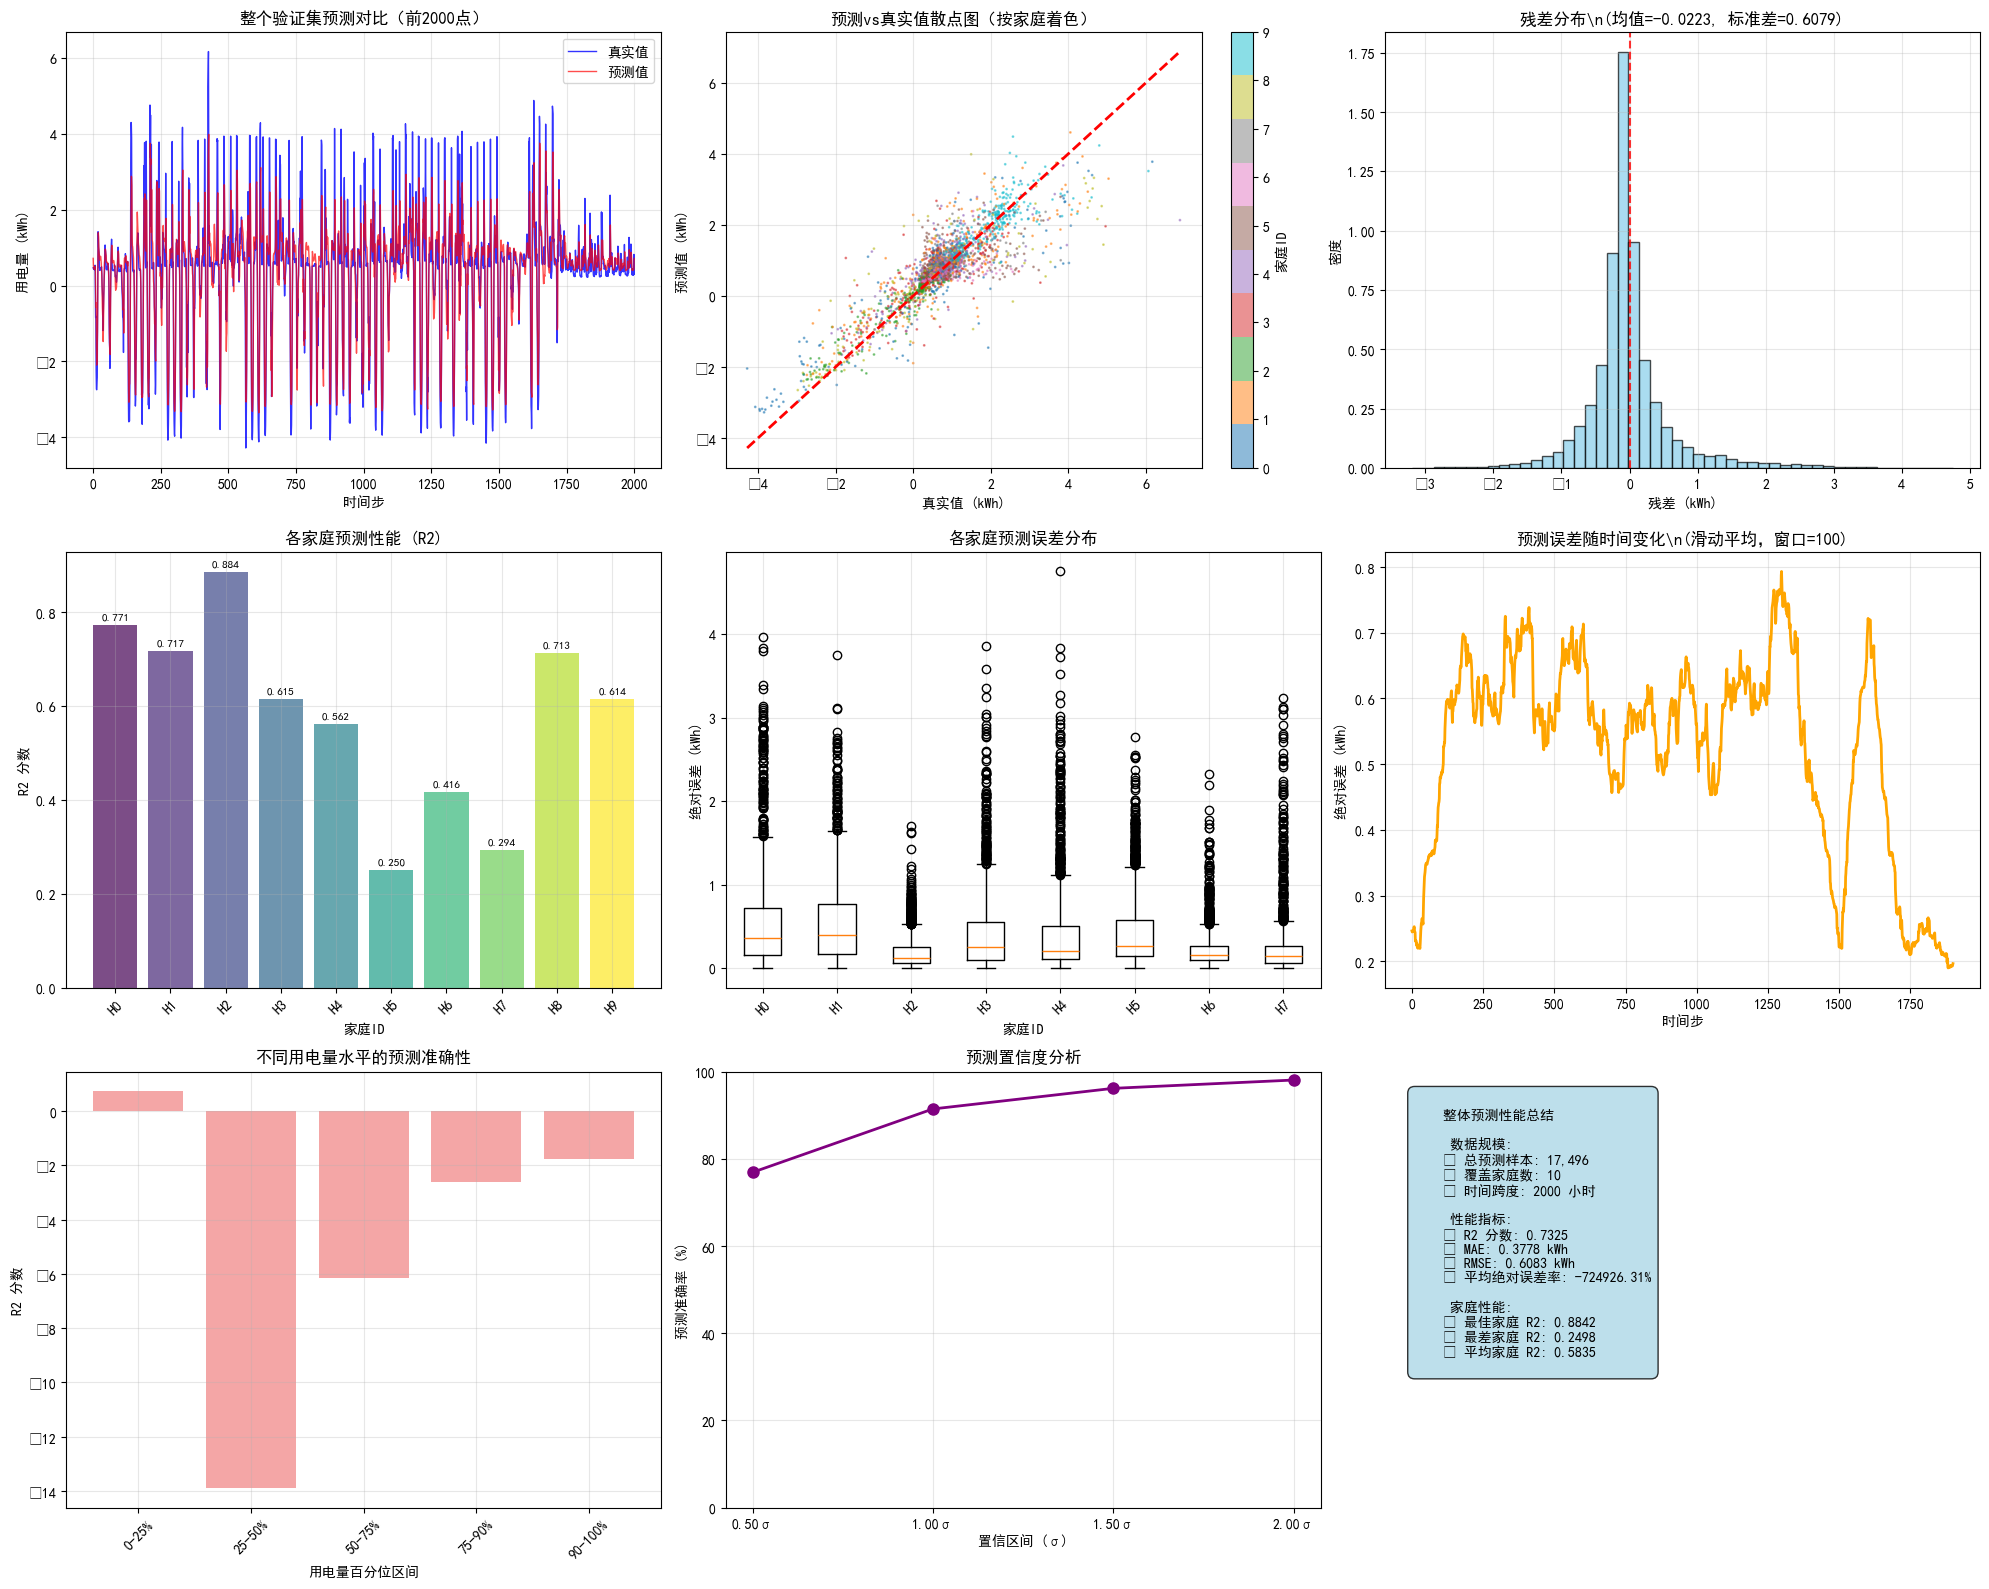

\n=== 详细家庭级别分析 ===


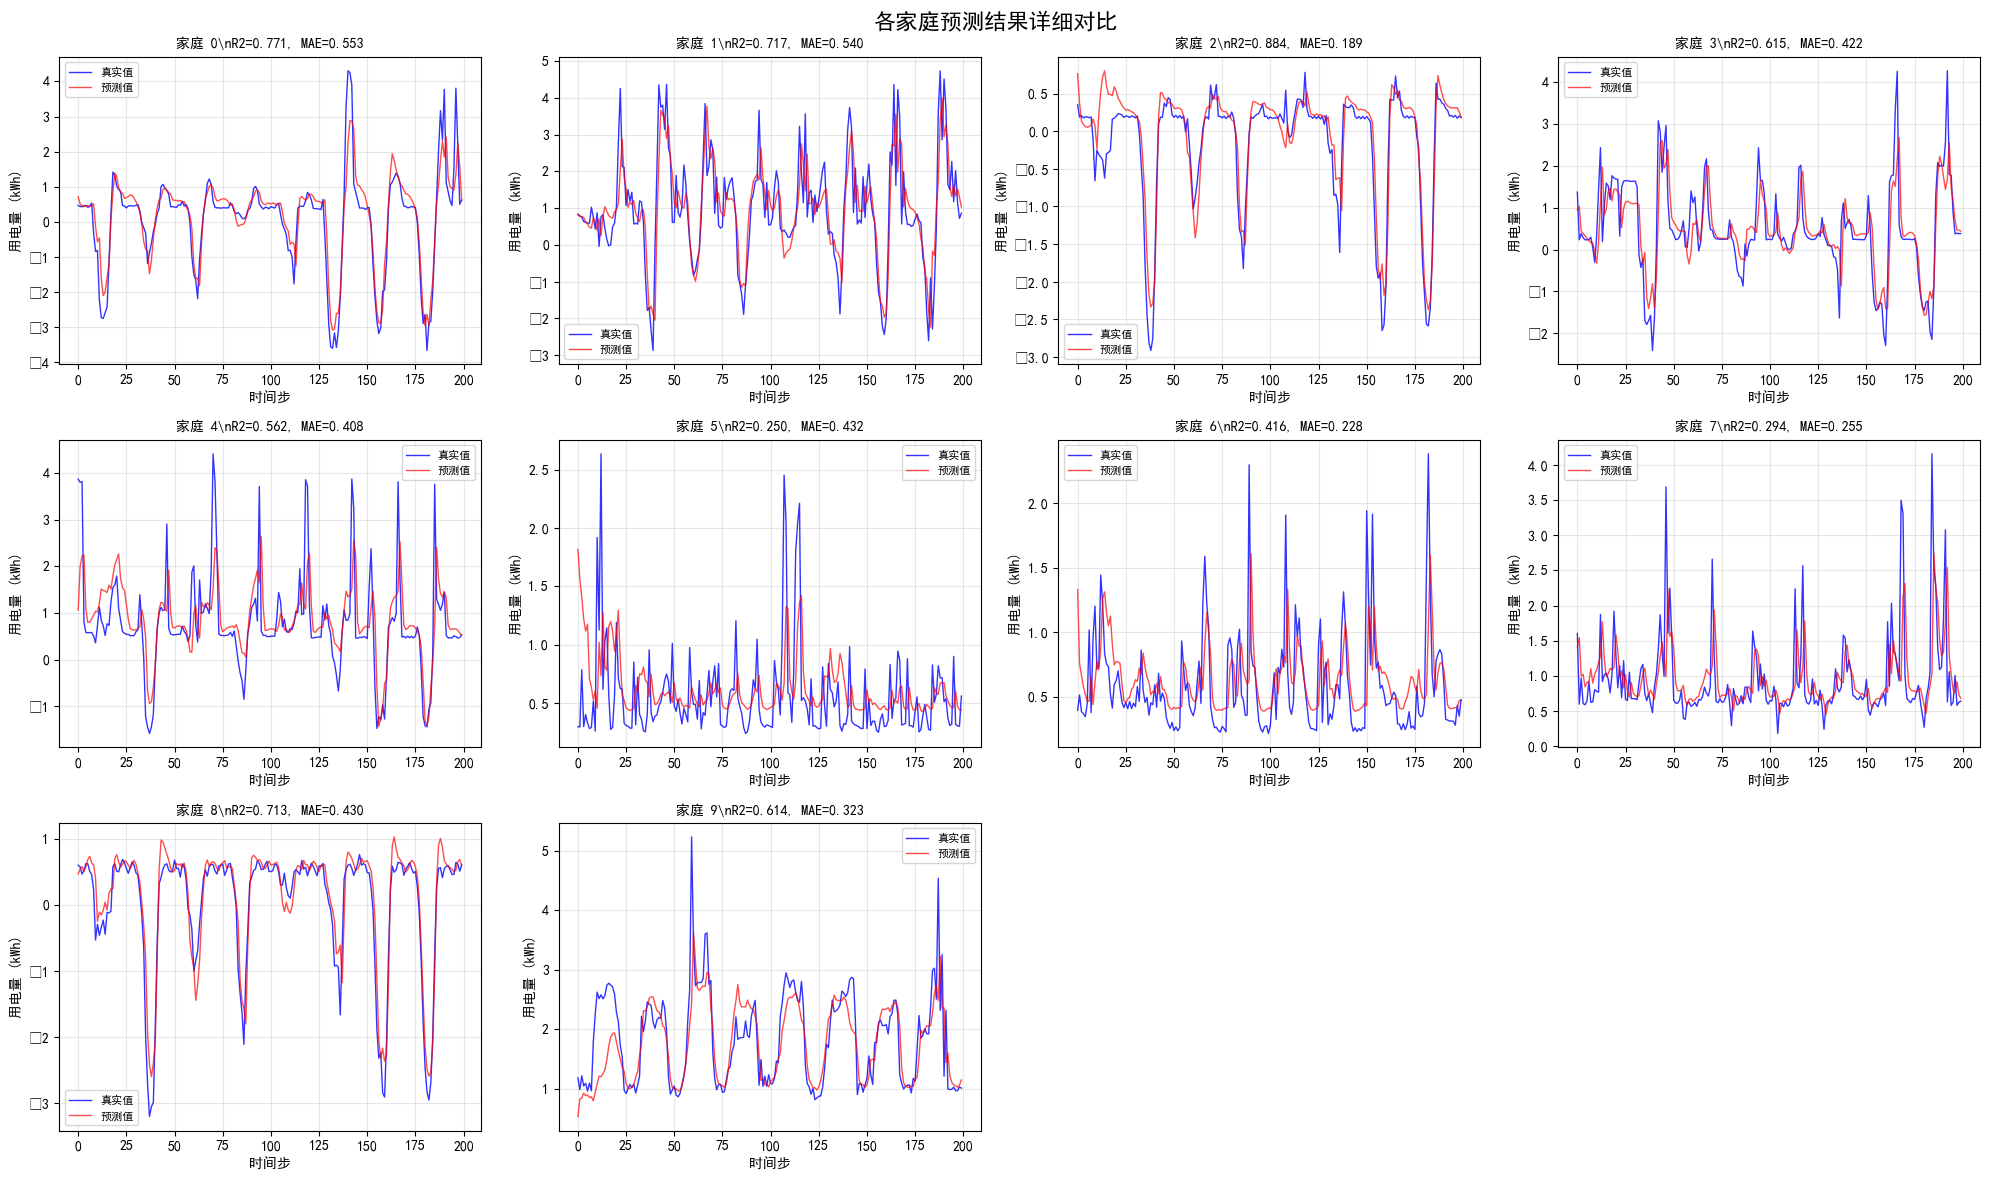

\n=== 详细数值分析报告 ===
家庭ID     样本数      R2分数       MAE        RMSE       平均用电      
----------------------------------------------------------------------
0        1728     0.7713     0.5533     0.8145     0.3326    
1        1752     0.7173     0.5403     0.7412     0.8857    
2        1752     0.8842     0.1892     0.2793     -0.1194   
3        1752     0.6152     0.4216     0.6511     0.4646    
4        1752     0.5619     0.4082     0.6687     0.7148    
5        1752     0.2498     0.4324     0.6162     0.8913    
6        1752     0.4159     0.2278     0.3330     0.6501    
7        1752     0.2936     0.2546     0.4701     0.8679    
8        1752     0.7126     0.4298     0.7475     0.4497    
9        1752     0.6138     0.3227     0.5216     1.9373    
\n=== 总体统计 ===
总体 R2 分数: 0.732454
总体 MAE: 0.377759 kWh
总体 RMSE: 0.608294 kWh
预测值范围: -3.3603 - 5.2059 kWh
真实值范围: -4.2882 - 6.8893 kWh
残差范围: -3.1975 - 4.7529 kWh


In [16]:
# 对整个验证集进行全面预测分析和可视化
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import defaultdict

warnings.filterwarnings('ignore')
# 设置中文字体，用于图表显示
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示负号
plt.rcParams['axes.unicode_minus'] = True

# 确保模型已加载
if 'model' not in locals() or 'val_loader' not in locals():
    print("⚠️ 请先运行前面的训练和评估单元格")
else:
    # 确保模型处于评估模式
    model.eval()
    
    # 重新收集验证集的所有预测结果，这次包含更多信息
    all_predictions = []
    all_targets = []
    all_household_ids = []
    all_sequences = []  # 存储输入序列
    
    print("正在收集验证集预测结果...")
    with torch.no_grad():
        for batch_idx, (x, household_ids, y) in enumerate(val_loader):
            x = x.to(device)
            household_ids = household_ids.to(device)
            
            # 获取预测
            y_pred = model(x, household_ids).squeeze()
            
            # 转换到CPU并存储
            all_predictions.extend(y_pred.cpu().numpy())
            all_targets.extend(y.numpy())
            all_household_ids.extend(household_ids.cpu().numpy())
            all_sequences.extend(x.cpu().numpy())
    
    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_household_ids = np.array(all_household_ids)
    all_sequences = np.array(all_sequences)
    
    # 反归一化到原始尺度
    predictions_original = scaler.inverse_transform(all_predictions.reshape(-1, 1)).flatten()
    targets_original = scaler.inverse_transform(all_targets.reshape(-1, 1)).flatten()
    
    print(f"共 {len(predictions_original)} 个预测样本")
    print(f"{len(np.unique(all_household_ids))} 个不同家庭")
    
    # 1. 创建综合可视化图表
    plt.figure(figsize=(20, 16))
    
    # 1.1 整体预测vs真实值时序图（显示前2000个点）
    plt.subplot(3, 3, 1)
    display_points = min(2000, len(predictions_original))
    time_indices = np.arange(display_points)
    plt.plot(time_indices, targets_original[:display_points], 
             label='真实值', color='blue', alpha=0.8, linewidth=1)
    plt.plot(time_indices, predictions_original[:display_points], 
             label='预测值', color='red', alpha=0.7, linewidth=1)
    plt.xlabel('时间步')
    plt.ylabel('用电量 (kWh)')
    plt.title(f'整个验证集预测对比（前{display_points}点）')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 1.2 预测vs真实值散点图
    plt.subplot(3, 3, 2)
    sample_indices = np.random.choice(len(predictions_original), 
                                     min(3000, len(predictions_original)), replace=False)
    plt.scatter(targets_original[sample_indices], predictions_original[sample_indices], 
               alpha=0.5, s=1, c=all_household_ids[sample_indices], cmap='tab10')
    plt.plot([targets_original.min(), targets_original.max()], 
             [targets_original.min(), targets_original.max()], 'r--', lw=2)
    plt.xlabel('真实值 (kWh)')
    plt.ylabel('预测值 (kWh)')
    plt.title('预测vs真实值散点图（按家庭着色）')
    plt.colorbar(label='家庭ID')
    plt.grid(True, alpha=0.3)
    
    # 1.3 残差分布
    plt.subplot(3, 3, 3)
    residuals = targets_original - predictions_original
    plt.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    plt.xlabel('残差 (kWh)')
    plt.ylabel('密度')
    plt.title(f'残差分布\\n(均值={np.mean(residuals):.4f}, 标准差={np.std(residuals):.4f})')
    plt.grid(True, alpha=0.3)
    
    # 1.4 按家庭分组的预测性能
    plt.subplot(3, 3, 4)
    unique_households = np.unique(all_household_ids)
    household_performance = {}
    
    for hid in unique_households:
        mask = all_household_ids == hid
        if np.sum(mask) > 10:  # 确保有足够样本
            h_targets = targets_original[mask]
            h_preds = predictions_original[mask]
            h_r2 = r2_score(h_targets, h_preds)
            h_mae = mean_absolute_error(h_targets, h_preds)
            household_performance[hid] = {'r2': h_r2, 'mae': h_mae, 'count': len(h_targets)}
    
    household_ids = list(household_performance.keys())
    r2_scores = [household_performance[hid]['r2'] for hid in household_ids]
    
    bars = plt.bar(range(len(household_ids)), r2_scores, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(household_ids))), alpha=0.7)
    plt.xlabel('家庭ID')
    plt.ylabel('R2 分数')
    plt.title('各家庭预测性能 (R2)')
    plt.xticks(range(len(household_ids)), [f'H{hid}' for hid in household_ids], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, (bar, score) in enumerate(zip(bars, r2_scores)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 1.5 误差分布箱线图（按家庭）
    plt.subplot(3, 3, 5)
    household_errors = []
    household_labels = []
    
    for hid in household_ids[:8]:  # 只显示前8个家庭避免图表过于拥挤
        mask = all_household_ids == hid
        if np.sum(mask) > 10:
            errors = np.abs(targets_original[mask] - predictions_original[mask])
            household_errors.append(errors)
            household_labels.append(f'H{hid}')
    
    plt.boxplot(household_errors, labels=household_labels)
    plt.ylabel('绝对误差 (kWh)')
    plt.xlabel('家庭ID')
    plt.title('各家庭预测误差分布')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 1.6 预测误差随时间变化
    plt.subplot(3, 3, 6)
    abs_errors = np.abs(residuals)
    # 计算滑动平均来平滑误差曲线
    window_size = 100
    if len(abs_errors) > window_size:
        smoothed_errors = np.convolve(abs_errors, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_errors[:display_points-window_size+1], color='orange', linewidth=2)
        plt.xlabel('时间步')
        plt.ylabel('绝对误差 (kWh)')
        plt.title(f'预测误差随时间变化\\n(滑动平均，窗口={window_size})')
        plt.grid(True, alpha=0.3)
    
    # 1.7 不同用电量水平的预测准确性
    plt.subplot(3, 3, 7)
    # 将真实值分为不同区间
    percentiles = [0, 25, 50, 75, 90, 100]
    quantiles = np.percentile(targets_original, percentiles)
    
    interval_r2 = []
    interval_labels = []
    
    for i in range(len(quantiles)-1):
        mask = (targets_original >= quantiles[i]) & (targets_original < quantiles[i+1])
        if np.sum(mask) > 10:
            interval_targets = targets_original[mask]
            interval_preds = predictions_original[mask]
            interval_r2.append(r2_score(interval_targets, interval_preds))
            interval_labels.append(f'{percentiles[i]}-{percentiles[i+1]}%')
    
    plt.bar(range(len(interval_r2)), interval_r2, color='lightcoral', alpha=0.7)
    plt.xlabel('用电量百分位区间')
    plt.ylabel('R2 分数')
    plt.title('不同用电量水平的预测准确性')
    plt.xticks(range(len(interval_labels)), interval_labels, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 1.8 模型预测置信度分析
    plt.subplot(3, 3, 8)
    # 计算预测的标准差作为不确定性度量
    prediction_std = np.std(predictions_original)
    confidence_intervals = [prediction_std * i for i in [0.5, 1.0, 1.5, 2.0]]
    
    accuracy_within_ci = []
    for ci in confidence_intervals:
        within_ci = np.sum(np.abs(residuals) <= ci) / len(residuals) * 100
        accuracy_within_ci.append(within_ci)
    
    plt.plot([f'{ci:.2f}σ' for ci in [0.5, 1.0, 1.5, 2.0]], accuracy_within_ci, 
             marker='o', linewidth=2, markersize=8, color='purple')
    plt.xlabel('置信区间 (σ)')
    plt.ylabel('预测准确率 (%)')
    plt.title('预测置信度分析')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    # 1.9 整体性能总结
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # 计算整体指标
    overall_r2 = r2_score(targets_original, predictions_original)
    overall_mae = mean_absolute_error(targets_original, predictions_original)
    overall_mse = mean_squared_error(targets_original, predictions_original)
    overall_rmse = np.sqrt(overall_mse)
    
    # 创建性能总结文本
    summary_text = f"""
    整体预测性能总结
    
     数据规模:
    • 总预测样本: {len(predictions_original):,}
    • 覆盖家庭数: {len(unique_households)}
    • 时间跨度: {display_points} 小时
    
     性能指标:
    • R2 分数: {overall_r2:.4f}
    • MAE: {overall_mae:.4f} kWh
    • RMSE: {overall_rmse:.4f} kWh
    • 平均绝对误差率: {np.mean(np.abs(residuals)/targets_original)*100:.2f}%
    
     家庭性能:
    • 最佳家庭 R2: {max(r2_scores):.4f}
    • 最差家庭 R2: {min(r2_scores):.4f}
    • 平均家庭 R2: {np.mean(r2_scores):.4f}
    """
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 2. 创建详细的家庭级别分析
    print("\\n=== 详细家庭级别分析 ===")
    
    plt.figure(figsize=(20, 12))
    
    # 为每个家庭创建子图（最多显示12个家庭）
    max_households_to_show = min(12, len(household_ids))
    cols = 4
    rows = (max_households_to_show + cols - 1) // cols
    
    for i, hid in enumerate(household_ids[:max_households_to_show]):
        plt.subplot(rows, cols, i+1)
        
        # 获取该家庭的数据
        mask = all_household_ids == hid
        h_targets = targets_original[mask]
        h_preds = predictions_original[mask]
        
        # 只显示前200个点避免图表过于密集
        display_len = min(200, len(h_targets))
        
        plt.plot(h_targets[:display_len], label='真实值', color='blue', alpha=0.8, linewidth=1)
        plt.plot(h_preds[:display_len], label='预测值', color='red', alpha=0.7, linewidth=1)
        
        # 计算该家庭的性能指标
        h_r2 = r2_score(h_targets, h_preds)
        h_mae = mean_absolute_error(h_targets, h_preds)
        
        plt.title(f'家庭 {hid}\\nR2={h_r2:.3f}, MAE={h_mae:.3f}', fontsize=10)
        plt.xlabel('时间步')
        plt.ylabel('用电量 (kWh)')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
    
    plt.suptitle('各家庭预测结果详细对比', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # 3. 生成详细的数值报告
    print("\\n=== 详细数值分析报告 ===")
    print(f"{'家庭ID':<8} {'样本数':<8} {'R2分数':<10} {'MAE':<10} {'RMSE':<10} {'平均用电':<10}")
    print("-" * 70)
    
    for hid in sorted(household_ids):
        mask = all_household_ids == hid
        h_targets = targets_original[mask]
        h_preds = predictions_original[mask]
        
        h_r2 = r2_score(h_targets, h_preds)
        h_mae = mean_absolute_error(h_targets, h_preds)
        h_rmse = np.sqrt(mean_squared_error(h_targets, h_preds))
        h_mean_consumption = np.mean(h_targets)
        
        print(f"{hid:<8} {len(h_targets):<8} {h_r2:<10.4f} {h_mae:<10.4f} {h_rmse:<10.4f} {h_mean_consumption:<10.4f}")
    
    print("\\n=== 总体统计 ===")
    print(f"总体 R2 分数: {overall_r2:.6f}")
    print(f"总体 MAE: {overall_mae:.6f} kWh")
    print(f"总体 RMSE: {overall_rmse:.6f} kWh")
    print(f"预测值范围: {predictions_original.min():.4f} - {predictions_original.max():.4f} kWh")
    print(f"真实值范围: {targets_original.min():.4f} - {targets_original.max():.4f} kWh")
    print(f"残差范围: {residuals.min():.4f} - {residuals.max():.4f} kWh")
    